Completed: 0.0 % flux: 0.0 u: 2.017152
Completed: 10.0 % flux: 0.0 u: 1318.784886851709
Completed: 20.0 % flux: 0.0 u: 1564.6540898931419
Completed: 30.0 % flux: 0.0 u: 1751.9406638133846
Completed: 40.0 % flux: 0.0 u: 1900.8843857453858
Completed: 50.0 % flux: 0.0 u: 2021.3687128167908
Completed: 60.0 % flux: 0.0 u: 2119.803836459379
Completed: 70.0 % flux: 0.0 u: 2200.791398465195
Completed: 80.0 % flux: 0.0 u: 2267.7905092150727
Completed: 90.0 % flux: 0.0 u: 2323.4685655929825
Completed: 100.0 % flux: 0.0 u: 2369.916282991894
Conduction:  1.0
Total simulation time: 50.0001 hours
K: 1e-10 m^2 Rayleigh-Darcy number: 3.483305496210897 Max heat 22.536867333521883 C


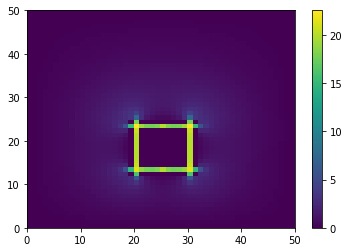

In [154]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

# box size, m
w = h = 1
# intervals in x-, y- directions, m
dx = dy = 0.02
# Thermal conductivity W/(m-K)
thermal_conductivity = 0.9
# Thermal diffusivity, m2.s-1
alphaSoil =  2.08e-7 #2.08e-7 m^2/s
alphaSteel = 1.172e-5 #m^2/s 1.172e-5 m^2/s
alphaWater = 1.39e-7 #m^2/s 1.39e-7 m^2/s
# Porosity
n = 0.4
# Viscosity kg/m
mu = 1.00E-03 
# Permeability m2s
k = 1e-10
# Thermal expansion 
beta = 8.80E-05
# Cf
cf = 4290
# rhow
rhow = 980
# gravity
g = 9.81 

# Set conduction to 0 to disable conduction
conduction = 1.

# Temperature of the cable
Tcool, Thot = 0, 70
# Flux
qx, qy = 1e3, 1e3

# pipe geometry
pr, pri, px, py = 0.1, 0.06, 0.62, 0.5 #0.59, 0.5
pr2 = pr**2
pri2 = pri**2

# Calculations
nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
#dt = dx2 * dy2 / (2 * alphaSoil * (dx2 + dy2))

dt = 0.0001 * 3600
#print("dt: {}, computed dt: {} critical dt: {}".format(dt, dx2 * dy2 / (2 * alphaSoil * (dx2 + dy2)), 1/(2 * alphaSoil * (dx2 + dy2))))

alpha = alphaSoil * np.ones((nx, ny))
u0 = Tcool * np.ones((nx, ny))
u = u0.copy()
uu = []

flux = np.zeros((nx, ny))
fluxx = np.zeros((nx, ny))
fluxy = np.zeros((nx, ny))

fflux = []
ffluxx = []
ffluxy = []


# Initial conditions
for i in range(nx):
    for j in range(ny):
        # Modify pipe alpha
        if ((i*dx-px)**2 + (j*dy-py)**2) < pr2 and ((i*dx-px)**2 + (j*dy-py)**2) > pri2:
            alpha[i,j] = alphaSteel
        # Modify pipe water alpha
        elif ((i*dx-px)**2 + (j*dy-py)**2) < pri2:
            alpha[i,j] = alphaWater
        
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit            
def do_timestep(u0, u, flux, fluxx, fluxy):
    # Propagate with forward-difference in time, central-difference in space, upwind solution for convection
    # Convection velocity term:
    # The velocity corresponds to differential density, since we are measuring the differnetial temp,
    # the rho(1 - beta(T)) is written as rho*(beta*DeltaT)
    '''
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + \
     + conduction * a[1:-1,1:-1] * dt * ((u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2 + \
          (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2) + \
    dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[1:-1,1:-1]-Tcool)) * \
    (u0[2:,1:-1] - u0[1:-1,1:-1])/(dy)
    '''
    # Set flux to zero
    flux = np.zeros((nx, ny))
    for i in range(nx): #nrows
        for j in range(ny): #ncols
            #pipe
            if (i*dx <= (px + pr + dx) and  i*dx >= (px - pr - dx)) and \
               (j*dy <= (py + pr + dx) and  j*dy >= (py - pr - dx)):
                # Set flux
                set_flux = False
                # Boundary index i and j
                bi, bj = i, j
                
                # +i quadrant
                if (i*dx >= (px + pr - dx/2) and  i*dx <= (px + pr + dx/2)):
                    bi, bj = i+1, j
                    qxs, qys = 0, -1.
                    u[i, j] = u0[i, j] + \
                        + conduction * dt *  (alpha[i, j]*(2 * u0[bi, j] - 2 * (u0[i,j] + dy*qy*qys)))/dy2 + \
                                          (np.minimum(alpha[i, j], alpha[i, j+1]) * (u0[i, j+1] - u0[i,j]) + \
                                           np.minimum(alpha[i, j], alpha[i, j-1]) * (u0[i,j-1] - u0[i,j]))/dx2 + \
                                                        dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[i,j]-Tcool)) * \
                                                        (u0[i+1,j] - u0[i,j])/(dy)

                # -i quadrant
                elif (i*dx >= (px - pr - dx/2) and  i*dx <= (px - pr + dx/2)):
                    bi, bj = i-1, j
                    qxs, qys = 0, -1.
                    u[i, j] = u0[i, j] + \
                        + conduction * dt *  (alpha[i, j]*(2 * u0[bi, j] - 2 * (u0[i,j] + dy*qy*qys)))/dy2 + \
                                          (np.minimum(alpha[i, j], alpha[i, j+1]) * (u0[i, j+1] - u0[i,j]) + \
                                           np.minimum(alpha[i, j], alpha[i, j-1]) * (u0[i,j-1] - u0[i,j]))/dx2 + \
                                                        dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[i,j]-Tcool)) * \
                                                        (u0[i+1,j] - u0[i,j])/(dy)
                
                # + j quadrant
                elif (j*dy >= (py + pr - dy/2) and  j*dy <= (py + pr + dy/2)):
                    bi, bj = i, j+1
                    qxs, qys = -1, 0.
                    u[i, j] = u0[i, j] + \
                        + conduction * dt * ((np.minimum(alpha[i, j], alpha[i+1, j]) *(u0[i+1, j] - u0[i,j]) + \
                                          np.minimum(alpha[i, j], alpha[i-1, j]) * (u0[i-1, j] - u0[i, j]))/dy2 + \
                                           (alpha[i, j]*(2 * u0[i, bj] - 2 * (u0[i,j] + dx*qx*qxs)))/dx2) + \
                                                        dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[i,j]-Tcool)) * \
                                                        (u0[i+1,j] - u0[i,j])/(dy)
                    
                # -j quadrant
                elif (j*dy >= (py - pr - dy/2) and  j*dy <= (py - pr + dy/2)):
                    bi, bj = i, j+1
                    qxs, qys = -1, 0.
                    u[i, j] = u0[i, j] + \
                        + conduction * dt * ((np.minimum(alpha[i, j], alpha[i+1, j]) *(u0[i+1, j] - u0[i,j]) + \
                                          np.minimum(alpha[i, j], alpha[i-1, j]) * (u0[i-1, j] - u0[i, j]))/dy2 + \
                                           (alpha[i, j]*(2 * u0[i, bj] - 2 * (u0[i,j] + dx*qx*qxs)))/dx2) + \
                                                        dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[i,j]-Tcool)) * \
                                                        (u0[i+1,j] - u0[i,j])/(dy)                                
                
            
            elif i > 0 and j > 0 and i < (nx -1) and j < (ny -1):
                # The velocity corresponds to differential density, since we are measuring the differnetial temp,
                # the rho(1 - beta(T)) is written as rho*(beta*DeltaT)
                u[i, j] = u0[i, j] + \
                    + conduction * dt * ((np.minimum(alpha[i, j], alpha[i+1, j]) *(u0[i+1, j] - u0[i,j]) + \
                                          np.minimum(alpha[i, j], alpha[i-1, j]) * (u0[i-1, j] - u0[i, j]))/dy2 + \
                                          (np.minimum(alpha[i, j], alpha[i, j+1]) * (u0[i, j+1] - u0[i,j]) + \
                                           np.minimum(alpha[i, j], alpha[i, j-1]) * (u0[i,j-1] - u0[i,j]))/dx2) + \
                                                        dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[i,j]-Tcool)) * \
                                                        (u0[i+1,j] - u0[i,j])/(dy)
                
              
    u0 = u.copy()
    return u0, u, flux, fluxx, fluxy

# Number of timesteps
nsteps = 500001
npercent = int(nsteps/100)
id = 0
fluxt = []
for m in range(nsteps):
    u0, u, flux, fluxx, fluxy = do_timestep(u0, u, flux, fluxx, fluxy)
    if m % (npercent * 10) == 0:
        uu.append(u.copy())
        fflux.append(flux.copy())
        ffluxx.append(fluxx.copy())
        ffluxy.append(fluxy.copy())
        print("Completed: {} % flux: {} u: {}".format(m/npercent, np.sum(flux[47:54, 42:58]), np.sum(uu[id])))
        fluxt.append(np.sum(flux[47:54, 42:58]))
        id = id + 1


print("Conduction: ", conduction)
max_heat = np.max(u)
print("Total simulation time: {} hours".format(dt * nsteps / 3600))
# Rayleigh number
ra = (rhow * g * (h -px) * k * beta * (max_heat-Tcool))/(mu*alphaSoil)
print("K: {} m^2 Rayleigh-Darcy number: {} Max heat {} C".format(k, ra, max_heat))

fig = plt.figure()
pcm = plt.pcolormesh(np.flipud(uu[len(uu)-1]))
#plt.xticks([0,40,80,120,160,200],[0,20,40,60,80,100])
#plt.yticks([0,40,80,120,160,200],[0,20,40,60,80,100])
plt.colorbar()
plt.show()

heat = u[:,20]
np.savetxt("heat.csv", heat, delimiter=",")

np.savetxt("flux.csv", fluxt, delimiter=",")

#pcm = plt.pcolormesh(np.flipud(fflux[len(fflux)-1]))
#plt.colorbar()    
#plt.show()


In [166]:
import math

def absolute_error(approximate_value, exact_value):
  """calculates the absolute error of two values"""
  abs_error = abs(exact_value - approximate_value)
  return abs_error

def relative_error(abs_error, exact_value):
  """calculates the relative error of two values"""
  rel_error = abs_error / exact_value
  return rel_error


def cos_taylor_expansion(x, nterms=10, tol=1e-5):
  """ calculates the taylor expansion of cos(ax) with set number of terms in the series """
  approximate_value = 0
  exact_value = math.cos(x)

  #loops for each value in 'terms' to calculate each term of the Taylor series and accumulates the sum
  for i in np.arange(nterms):
    term = ((-1)**i * (x)**(2*i)) / (math.factorial(2*i))
    
    approximate_value += term


  abs_error = absolute_error(approximate_value, exact_value)
  rel_error = relative_error(abs_error, exact_value)

  return approximate_value, abs_error, rel_error

#initial constant value
a = 2

#value of x
x = 0.5
x = x * a

#terms to be evaluated within the Taylor series
terms = 4

approximate_value, abs_error, rel_error = cos_taylor_expansion(x, nterms=4)


print("The approximate value evaluated using {} terms of the Taylor series is {}.".format(terms, approximate_value))
print("The absolute error or truncation error is {} and the relative error is {}.".format(abs_error, rel_error))


1.0 1 1
-0.5 1 2
0.041666666666666664 2 24
-0.001388888888888889 6 720
The approximate value evaluated using 4 terms of the Taylor series is 0.5402777777777777.
The absolute error or truncation error is 2.4528090362019306e-05 and the relative error is 4.539697516672335e-05.
